In [80]:
#%% Import modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.cm as cm
from nets_predict.classes.hmm import HiddenMarkovModelClass
from nets_predict.classes.partial_correlation import PartialCorrelationClass

HMMClass = HiddenMarkovModelClass()
PartialCorrClass = PartialCorrelationClass()


In [81]:
# set parameters for script
n_chunk = 4
n_ICs = 25
n_edge = int((n_ICs * (n_ICs - 1))/2)
n_states = 8

In [82]:
# set project directories
proj_dir = '/gpfs3/well/win-fmrib-analysis/users/psz102/nets-predict/nets_predict'
load_dir = f"{proj_dir}/results/ICA_{n_ICs}/edge_prediction/{n_chunk}_chunks/combined"

# decide which featured to examine
feature_prediction_dict = dict()
feature_prediction_dict['actual'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_actual.npz")
feature_prediction_dict['static'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_static_states_0_model_mean_True.npz")
feature_prediction_dict['fc'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_fc_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['pc'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_pc_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['all'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_all_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['means'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_means_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['tpms_ss'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_tpms_ss_states_{n_states}_model_mean_True.npz")
feature_prediction_dict['tpms_ss_only'] = np.load(f"{load_dir}/edge_prediction_all_nm_icov_pm_icov_chunks_{n_chunk}_features_used_tpms_ss_only_states_{n_states}_model_mean_True.npz")

In [83]:
# load ground truth matrix
ground_truth_dir = f"{proj_dir}/results/ICA_{n_ICs}/ground_truth"
ground_truth_matrix = np.load(f"{ground_truth_dir}/ground_truth_partial_mean_4_sessions.npy")

# extract upper diagonal (excluding main diagonal) 
ground_truth_icov_reshape = PartialCorrClass.extract_upper_off_main_diag(ground_truth_matrix)

# take mean ground truth across subjects
ground_truth_icov_reshape_mean = np.mean(ground_truth_icov_reshape,axis=0)


In [84]:
static_dir = f"{proj_dir}/results/ICA_{n_ICs}/static"
partial_correlations_chunk = np.load(f"{static_dir}/partial_correlations_{n_chunk}_chunks.npy")
print(partial_correlations_chunk.shape)
partial_correlations_chunk_flatten = PartialCorrClass.extract_upper_off_main_diag(partial_correlations_chunk)
print(partial_correlations_chunk_flatten.shape)

(1003, 4, 25, 25)
(1003, 4, 300)


In [85]:
################## WE FIRST LOOK AT PLOTTING STATICS ##################

In [86]:
################## WE NOW INTRODUCE DYNAMICS ##################

# note how many dynamic features are being used and print what they are
n_feat_type = len(feature_prediction_dict) 
print(n_feat_type)
print(*feature_prediction_dict)

8
actual static fc pc all means tpms_ss tpms_ss_only


alpha l1_ratio corr_y predict_y beta accuracy_per_edge


/tmp/ipykernel_161513/978107787.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('twilight_shifted')


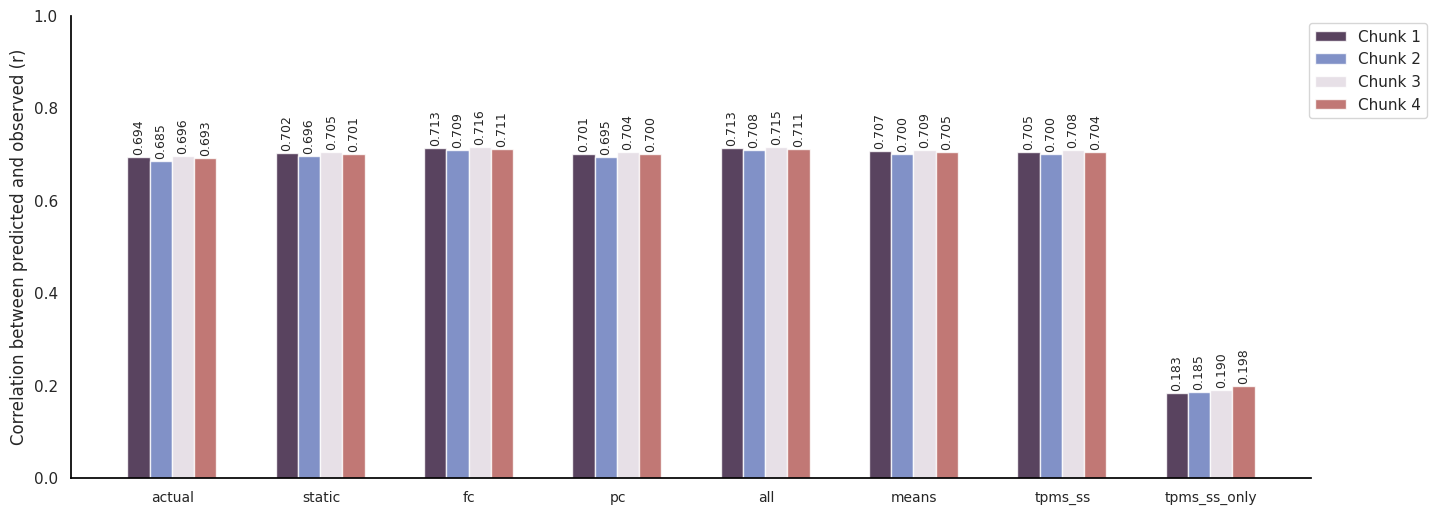

In [87]:
##################### Plot bar chart of accuracies across HMM feature groups ########################


# let's combine the prediction accuracies for each hmm features into a combined array
hmm_features_accuracy = np.zeros((n_feat_type, n_chunk, n_edge))
feat_num = 0
labels = []
for key, value in feature_prediction_dict.items():
    hmm_features_accuracy[feat_num,:,:] = value['accuracy_per_edge']
    labels.append(key) # create labels for plot
    feat_num += 1
    
    
print(*feature_prediction_dict['static'])

# if we want to remove nan subjects see commented code at end of script

# Here we split up the accuracy of the chunks for using partial correlations to predict partial correlations
# Create a colormap with a smooth transition of colors
cmap = cm.get_cmap('twilight_shifted')

# Define the number of colors needed
num_colors = n_chunk

# Get a list of colors from the colormap
colors = [cmap(i / num_colors) for i in range(num_colors)]

# Create a new figure for the grouped bar chart with a larger size
fig, ax = plt.subplots(figsize=(16, 6))

# Set bar width, group offset, and x-positions of bars
x = np.arange(len(labels))
if n_chunk == 4:
    bar_width = 0.15
    group_offset = (len(labels)) * bar_width
elif n_chunk == 12:
    bar_width = 0.05
    group_offset = (len(labels) + 8) * bar_width

# Iterate over the traits
for i in range(n_chunk):
    chunk_plot = hmm_features_accuracy[:,i,:]

    # Calculate the mean values for each bar
    means = np.mean(chunk_plot, axis=1)

    # Calculate the x-axis positions for the bars within a group
    x_grouped = x + (i - 2) * bar_width - group_offset + 0.37

    # Plot the bars within a group
    bars = ax.bar(x_grouped, means, width=bar_width, color=colors[i % num_colors], alpha=0.8)

    # Add text labels on top of each bar with decreased fontsize
    for bar in bars:
        height = bar.get_height()
        if n_chunk == 4:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=9, rotation=90)
        elif n_chunk == 12:
            ax.text(bar.get_x() + bar.get_width() / 2, height+0.005, f'{height:.3f}', ha='center', va='bottom', fontsize=6, rotation=90)

# Set the y-axis label
ax.set_ylabel('Correlation between predicted and observed (r)', fontsize=12)

# Set the x-axis tick labels and move them to the left
if n_chunk == 4:
    ax.set_xticks(x - 0.9)
elif n_chunk == 12:
    ax.set_xticks(x - 0.25)

ax.set_xticklabels(labels, fontsize=10)

# Add a legend for the eight bars
ax.legend(labels=['Chunk ' + str(i+1) for i in range(n_chunk)], loc='upper right', bbox_to_anchor=(1.1, 1.0))

# Remove the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Set the y-axis limits to range from 0.7 to 1
ax.set_ylim(0, 1)
#ax.set_ylim(np.nanmin(means)-0.05, np.nanmax(means)+0.1)

# Remove the grid
ax.grid(False)

# Set the color of the x and y axis lines to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Show the plot
plt.show()

8
(1200,)


/tmp/ipykernel_161513/268557528.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_161513/268557528.py:23: UserWarning: 
The palette list has fewer values (7) than needed (8) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)
/tmp/ipykernel_161513/268557528.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


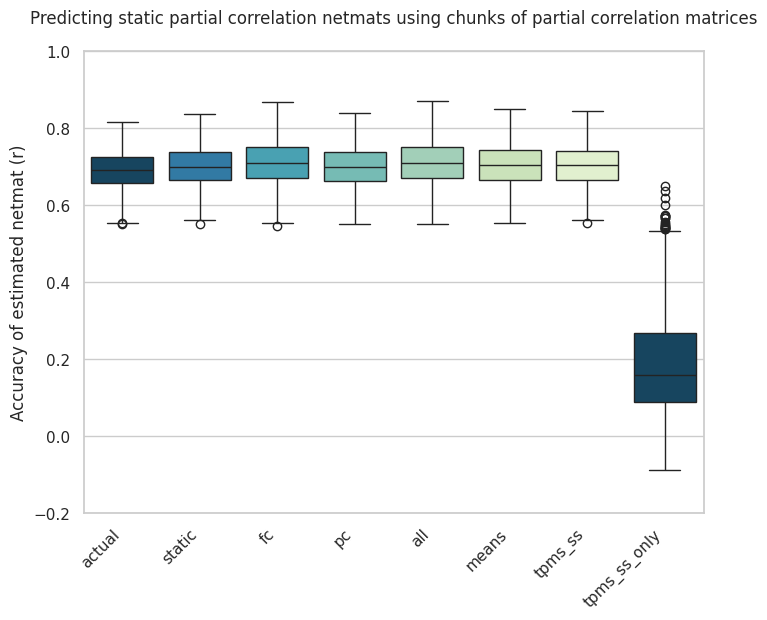

In [88]:
##################### Plot box plots of accuracies across HMM feature groups (across edges)  ########################

# transform array to list to make dataframe to pot as boxplots across edges
hmm_features_accuracy_list = []

for j in range(n_feat_type):
    hmm_features_accuracy_list.append(hmm_features_accuracy[j,:,:].flatten())

print(len(hmm_features_accuracy_list))
print(hmm_features_accuracy_list[0].shape)


# Create a dataframe with the data and group names
df = pd.DataFrame({'Group': np.repeat(labels, [hmm_features_accuracy_list[i].shape[0] for i in range(len(labels))]),
                   'Value': np.concatenate(hmm_features_accuracy_list)})

# Create the grouped boxplot using Seaborn
colors = ['#0B486B', '#1f7fb7', '#38adc3', '#6bc6bd', '#9ad6b8', '#c8e9b3', '#e1f5ca']
#colors = ['#0B486B', '#6bc6bd']
sns.set(style="whitegrid")
#sns.set(style="white")
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Group', y='Value', data=df, palette=colors)

# Set the x-axis and y-axis labels
plt.xlabel('')
plt.ylabel('Accuracy of estimated netmat (r)')

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

ymin = -0.2  # Minimum y-value
ymax = 1  # Maximum y-value
ax.set_ylim(ymin, ymax)


# Set the title
plt.title("Predicting static partial correlation netmats using chunks of partial correlation matrices", fontsize=12, pad=20)

# Show the plot
plt.show()

In [89]:
print(*feature_prediction_dict['fc'])

alpha l1_ratio corr_y predict_y beta accuracy_per_edge


In [90]:
print(feature_prediction_dict['fc']['beta'].shape)
print(feature_prediction_dict['all']['beta'].shape)
# 2900 because you want the main diagonal so you keep (25 x 26)/2 (2600 for fc) + 300 (for static)
# 5596 because 2400 for PC (exlcuding main diagonal), 2600 for FC, ,  25*8 (200 for means), 300 for static, 8*8 (64 for TPMs), 4*8 (32 for SS)
# in this order:
# feat = np.concatenate([feat_icovs, feat_covs, feat_means, feat_tpm, feat_ss],axis=1)

beta_all_abs = np.mean(np.mean(np.abs(feature_prediction_dict['all']['beta']), axis=2), axis=1)
beta_all = np.mean(np.mean(feature_prediction_dict['all']['beta'], axis=2), axis=1)
beta_all.shape

(4, 10, 300, 2900)
(4, 10, 300, 5596)


(4, 5596)

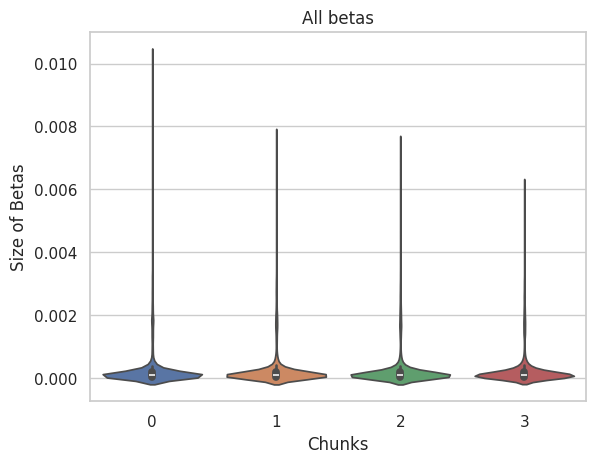

In [91]:
# Create a new figure
fig = plt.figure()

# Set the title
plt.title("All betas")

# Create the violin plot with four violins
sns.violinplot(data=beta_all_abs.T)

# Set the x-axis label
plt.xlabel("Chunks")

# Set the y-axis label
plt.ylabel("Size of Betas")

# Show the figure
plt.show()

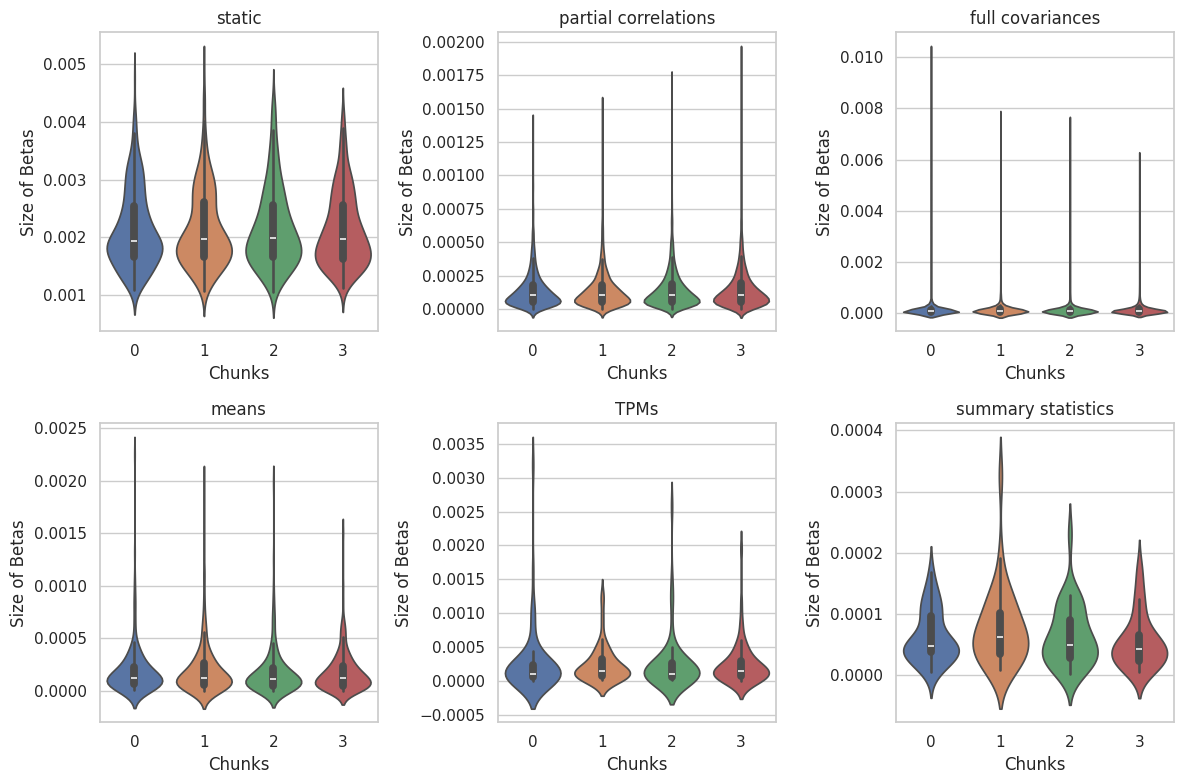

In [92]:
# Define the indices for each type of element
indices = {
    "static": (0, 300),
    "partial correlations": (300, 2700),
    "full covariances": (2700, 5300),
    "means": (5300, 5500),
    "TPMs": (5500, 5564),
    "summary statistics": (5564, 5596)
}

# Extract sections
beta_sections = {key: beta_all_abs[:, start:end] for key, (start, end) in indices.items()}

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjust figsize as needed

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create violin plots for each section
for i, (key, data) in enumerate(beta_sections.items()):
    ax = axes[i]
    sns.violinplot(data=data.T, ax=ax)  # Transpose data to have 4 violins for each type
    ax.set_title(key)
    ax.set_xlabel("Chunks")
    ax.set_ylabel("Size of Betas")

# Adjust layout to fit plots into the figure area
plt.tight_layout()

# Show the figure
plt.show()


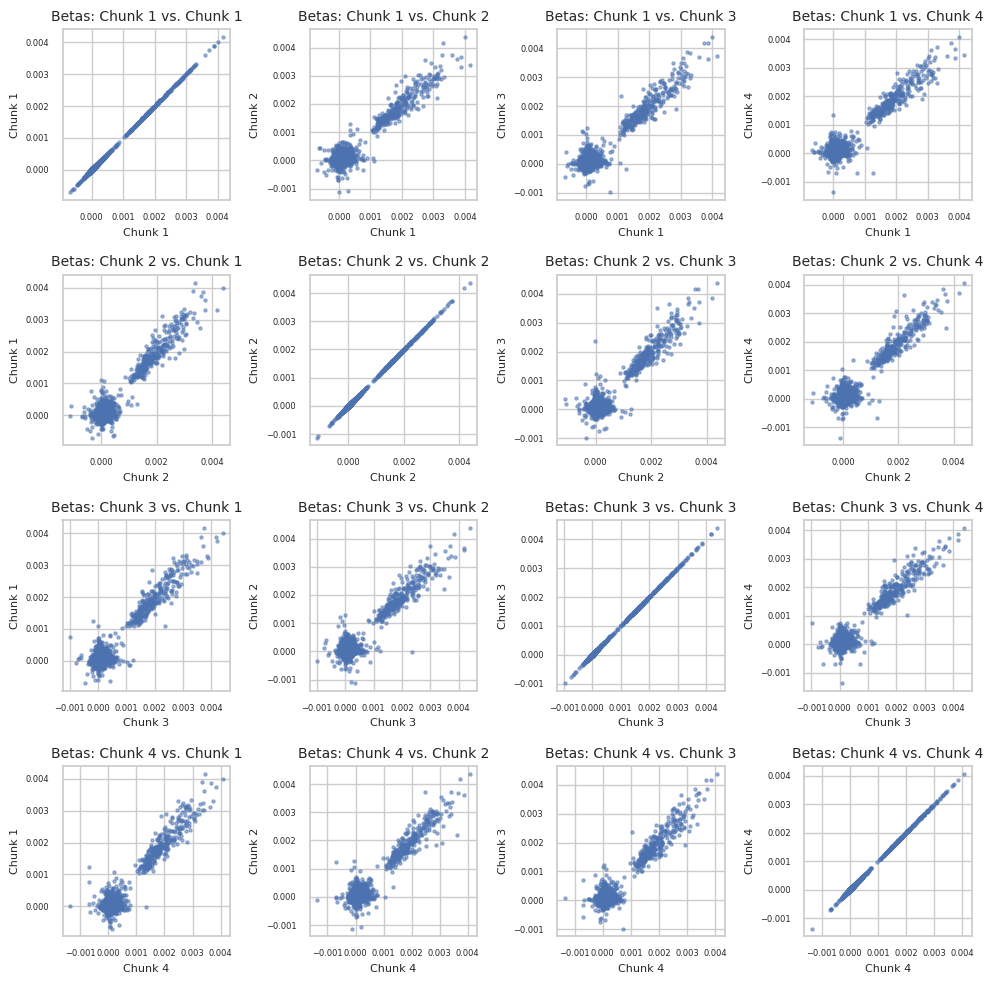

In [93]:
# Create a figure with 16 subplots (4 rows, 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Adjust figsize as needed

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Create scatter plots for each pair of chunks
for i in range(4):
    for j in range(4):
        ax = axes[i * 4 + j]
        ax.scatter(beta_all[i, :], beta_all[j, :], alpha=0.5, s=5)  # Set `s` to control point size
        ax.set_xlabel(f"Chunk {i+1}", fontsize=8)  # Set font size for x-axis labels
        ax.set_ylabel(f"Chunk {j+1}", fontsize=8)  # Set font size for y-axis labels
        ax.set_title(f"Betas: Chunk {i+1} vs. Chunk {j+1}", fontsize=10)  # Set font size for titles
        ax.tick_params(axis='both', which='major', labelsize=6)  # Set font size for tick labels

# Adjust layout to fit plots into the figure area
plt.tight_layout()

# Show the figure
plt.show()

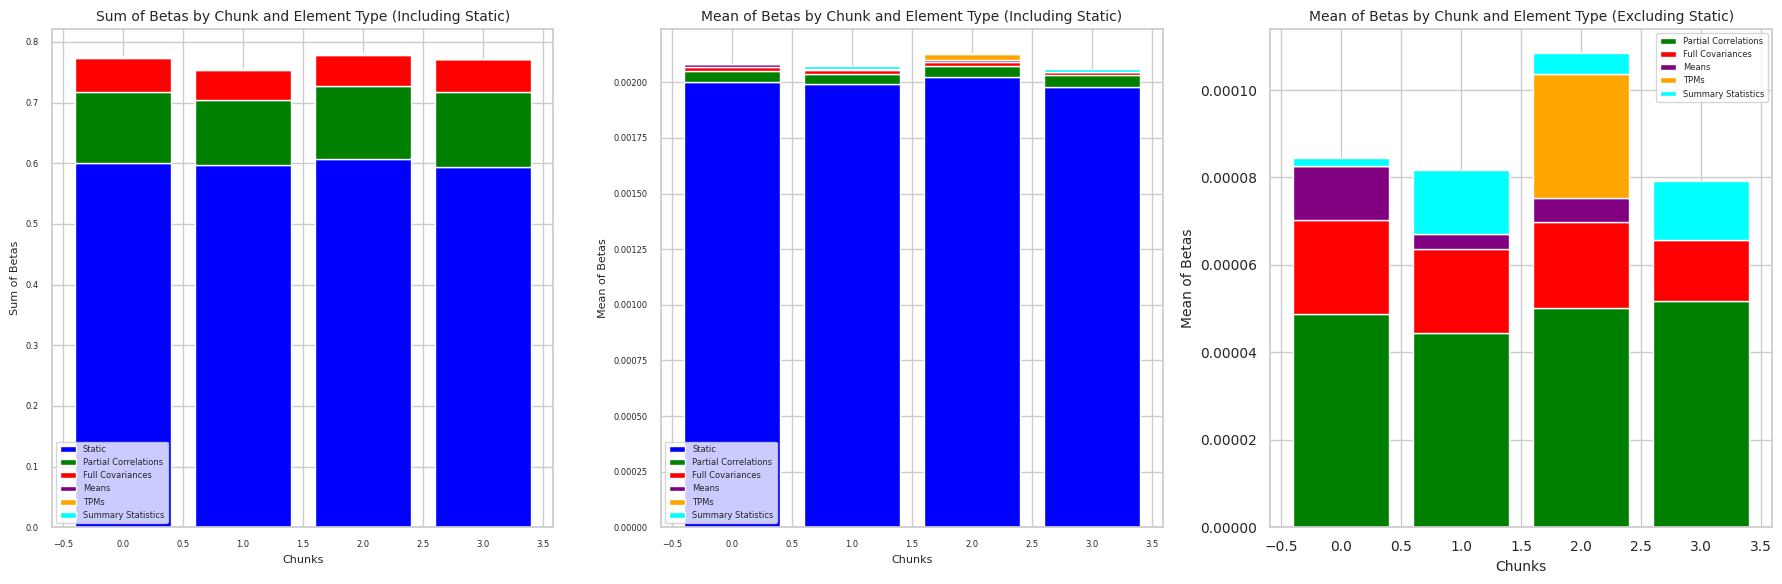

In [94]:
# Define the element types and their ranges
element_types_including_static = {
    "Static": (0, 300),
    "Partial Correlations": (300, 2700),
    "Full Covariances": (2700, 5300),
    "Means": (5300, 5500),
    "TPMs": (5500, 5564),
    "Summary Statistics": (5564, 5596)
}

element_types_excluding_static = {
    "Partial Correlations": (300, 2700),
    "Full Covariances": (2700, 5300),
    "Means": (5300, 5500),
    "TPMs": (5500, 5564),
    "Summary Statistics": (5564, 5596)
}

# Calculate the sums and means for each element type and chunk
sums_by_element_type_including_static = {key: np.sum(beta_all[:, start:end], axis=1) for key, (start, end) in element_types_including_static.items()}
means_by_element_type_including_static = {key: np.mean(beta_all[:, start:end], axis=1) for key, (start, end) in element_types_including_static.items()}
means_by_element_type_excluding_static = {key: np.mean(beta_all[:, start:end], axis=1) for key, (start, end) in element_types_excluding_static.items()}

# Set the figure size and create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colors for each element type
colors = ["blue", "green", "red", "purple", "orange", "cyan"]

# Plot 1: Sum of Betas by Chunk and Element Type (Including Static)
ax = axes[0]
bottom = np.zeros(4)
for (element, color) in zip(element_types_including_static.keys(), colors):
    ax.bar(range(4), sums_by_element_type_including_static[element], bottom=bottom, label=element, color=color)
    bottom += sums_by_element_type_including_static[element]
ax.set_xlabel("Chunks", fontsize=8)
ax.set_ylabel("Sum of Betas", fontsize=8)
ax.set_title("Sum of Betas by Chunk and Element Type (Including Static)", fontsize=10)
ax.legend(fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

# Plot 2: Mean of Betas by Chunk and Element Type (Including Static)
ax = axes[1]
bottom = np.zeros(4)
for (element, color) in zip(element_types_including_static.keys(), colors):
    ax.bar(range(4), means_by_element_type_including_static[element], bottom=bottom, label=element, color=color)
    bottom += means_by_element_type_including_static[element]
ax.set_xlabel("Chunks", fontsize=8)
ax.set_ylabel("Mean of Betas", fontsize=8)
ax.set_title("Mean of Betas by Chunk and Element Type (Including Static)", fontsize=10)
ax.legend(fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)

# Plot 3: Mean of Betas by Chunk and Element Type (Excluding Static)
ax = axes[2]
bottom = np.zeros(4)
for (element, color) in zip(element_types_excluding_static.keys(), colors[1:]):  # Exclude the first color for Static
    ax.bar(range(4), means_by_element_type_excluding_static[element], bottom=bottom, label=element, color=color)
    bottom += means_by_element_type_excluding_static[element]
ax.set_xlabel("Chunks", fontsize=10)
ax.set_ylabel("Mean of Betas", fontsize=10)
ax.set_title("Mean of Betas by Chunk and Element Type (Excluding Static)", fontsize=10)
ax.legend(fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to fit plots into the figure area
plt.tight_layout()

# Show the figure
plt.show()


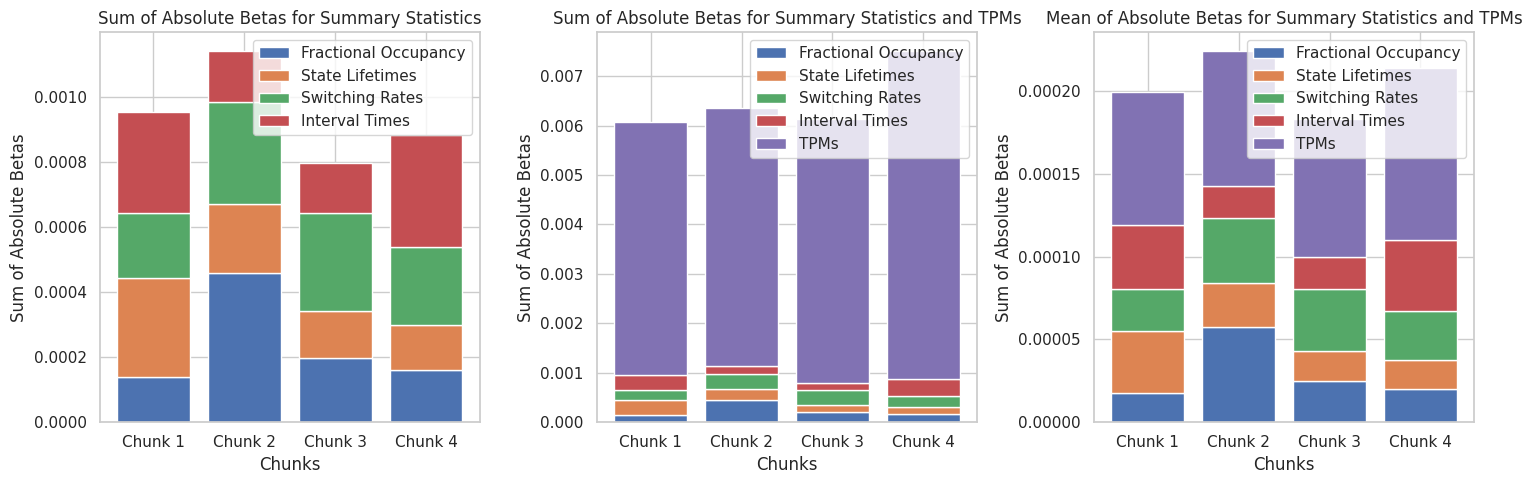

In [95]:
# Define the ranges for each subset of "Summary Statistics" and TPMs
summary_stats_ranges = {
    "Fractional Occupancy": (5564, 5572),
    "State Lifetimes": (5572, 5580),
    "Switching Rates": (5580, 5588),
    "Interval Times": (5588, 5596),
    "TPMs": (5500, 5564)
}

# Calculate the sum of absolute values for each subset of "Summary Statistics" (excluding TPMs)
sum_abs_betas_by_summary_stats = {key: np.sum(np.abs(beta_all[:, start:end]), axis=1) for key, (start, end) in summary_stats_ranges.items() if key != "TPMs"}

# Calculate the sum of absolute values for each subset of "Summary Statistics" (including TPMs)
sum_abs_betas_by_summary_stats_with_tpm = {key: np.sum(np.abs(beta_all[:, start:end]), axis=1) for key, (start, end) in summary_stats_ranges.items()}

# Calculate the mean of absolute values for each subset of "Summary Statistics" (including TPMs)
mean_abs_betas_by_summary_stats_with_tpm = {key: np.mean(np.abs(beta_all[:, start:end]), axis=1) for key, (start, end) in summary_stats_ranges.items()}

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the sum of absolute betas for "Summary Statistics" (excluding TPMs)
for i, (subset, data) in enumerate(sum_abs_betas_by_summary_stats.items()):
    axes[0].bar(np.arange(4), data, label=subset, bottom=np.sum(list(sum_abs_betas_by_summary_stats.values())[:i], axis=0) if i > 0 else None)

# Plot the sum of absolute betas for "Summary Statistics" (including TPMs)
for i, (subset, data) in enumerate(sum_abs_betas_by_summary_stats_with_tpm.items()):
    axes[1].bar(np.arange(4), data, label=subset, bottom=np.sum(list(sum_abs_betas_by_summary_stats_with_tpm.values())[:i], axis=0) if i > 0 else None)

# Plot the mean of absolute betas for "Summary Statistics" (including TPMs)
for i, (subset, data) in enumerate(mean_abs_betas_by_summary_stats_with_tpm.items()):
    axes[2].bar(np.arange(4), data, label=subset, bottom=np.sum(list(mean_abs_betas_by_summary_stats_with_tpm.values())[:i], axis=0) if i > 0 else None)

# Add labels and titles
titles = ["Sum of Absolute Betas for Summary Statistics",
          "Sum of Absolute Betas for Summary Statistics and TPMs",
          "Mean of Absolute Betas for Summary Statistics and TPMs"]
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_xlabel("Chunks")
    ax.set_ylabel("Sum of Absolute Betas")
    ax.set_xticks(range(4))
    ax.set_xticklabels([f"Chunk {i+1}" for i in range(4)])
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


